In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm


if not sys.warnoptions:
    warnings.simplefilter('ignore')

sns.set()
tf.compat.v1.random.set_random_seed(1234)

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

In [50]:
df = pd.read_csv('C:\Jupyter_Project\HYSS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-02-07,9260.0,9370.0,9260.0,9350.0,5701.586426,6719.0
1,2011-02-08,9290.0,9340.0,9280.0,9310.0,5677.194824,10192.0
2,2011-02-09,9310.0,9310.0,9240.0,9280.0,5658.900879,15543.0
3,2011-02-10,9280.0,9280.0,9180.0,9190.0,5604.019531,21580.0
4,2011-02-11,9190.0,9270.0,9050.0,9060.0,5524.746094,33565.0


In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.770335  0.767857  0.853147  0.804878  0.002402
1     0.775120  0.762987  0.856643  0.798374  0.003644
2     0.778309  0.758117  0.849650  0.793496  0.005557
3     0.773525  0.753247  0.839161  0.778862  0.007715
4     0.759171  0.751623  0.816434  0.757724  0.012000
...        ...       ...       ...       ...       ...
2459  0.816587  0.805195  0.833916  0.790244  0.050171
2460  0.760766  0.785714  0.825175  0.809756  0.029087
2461  0.802233  0.839286  0.888112  0.861789  0.037810
2462  0.864434  0.902597  0.947552  0.908943  0.061125
2463  0.904306  0.902597  0.972028  0.934959  0.047673

[2464 rows x 5 columns]


In [52]:
window_size = 20
TEST_SIZE = 60

In [53]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [54]:
# 정해진 window_size에 기반하여 20일 기간의 데이터 셋을 묶어준다

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [55]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((1907, 20, 4), (477, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((60-20, 20, 4), (60-20, 1))

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [26]:
x_train.shape

(1907, 20, 4)

In [27]:
x_valid.shape

(477, 20, 4)

In [28]:
y_train.shape

(1907, 1)

In [36]:
test_feature.shape

(40, 20, 4)

In [39]:
validation_data = (x_valid, y_valid)

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [47]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# x : 입력데이터(1907문항), y : 라벨 값(1907문제의 해답지), batch_size : 몇 개의 샘플로 가중치를 갱신할 것인지 지정
# batch_size = 1 -> 1문항을 풀고 난 뒤에 해답을 맞춰보기(가중치 갱신은 1907번 발생)
# validation_data : train data*0.2 로써 학습 중에 평가하는 구간이다
# epochs = 모의고사 1회분을 200번 푼다. 같은 문제집을 여러번 풀면서 모델도 반복적으로 가중치를 갱신하면서 모델이 학습된다
# Overfitting을 막기 위해 early_stop 할 수 있도록 설계한다

history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=1,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

NameError: name 'model_path' is not defined

In [33]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

In [38]:
pred.shape

(40, 1)

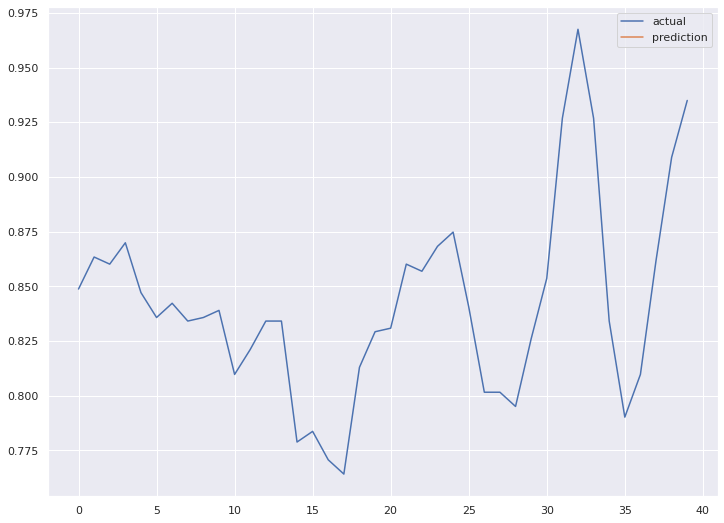

In [34]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()